# TODO
- compare 95, 75, 50 simulations to test cut_prob estimation
- attempt to compare simulation mapped sites to the original raw data start/end sites
- get cut prob of snipen data (and see if it holds across the 20 samples and 3 reps)

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from random import randint

In [2]:
def generate_list(n, cut_prob):
    s = ''
    for i in range(n):
#         s += str(randint(0, 1))
        s += str(random.choices([0, 1], [1-cut_prob, cut_prob])[0])
    return s


def and_gate(a, b):
    c = bin(int(a, base=2) & int(b, base=2))[2:]
    c = c.count('1')
    return c


n = 10
cut_prob = .75
mx = []

for i in range(10):
    mx.append([generate_list(n, cut_prob)])
mx = np.array(mx)
print(mx)

[['1111000100']
 ['1010100111']
 ['0011111011']
 ['1111111110']
 ['1011001110']
 ['1111111111']
 ['0111101011']
 ['1110101011']
 ['1101101111']
 ['1100111011']]


### new approach, based entirely on probability of fragment within a given window

In [3]:
def prob_dictionary(cut_prob, site_range):
    '''
    the probability for each site 0 to site i fragment surviving is
    the product of the probability of the sites 0 and i being cut and
    the intermediate sites not being cut
    '''
    prob_dt = {}
    for i in range(1, site_range):
        prob_dt[(0, i)] = (cut_prob ** 2) * ((1-cut_prob)**(i-1))

    return prob_dt


def get_read_counts(prob_dt, n):
    read_counts = {}
    for k, v in prob_dt.items():
        counts = v*n
#         print(f'{k} : {counts}')
        read_counts[k] = counts
        
    return read_counts


def print_ratios(read_counts):
    for k, v in read_counts.items():
        if k == (0, 1):
            last =  v
        else:
            ratio = last / v
#             print(ratio)
            last = v
    return ratio
  
    
def define_clusters(site_ls, window):
    for idx, site in enumerate(site_ls):
        cluster = [site]
        for sub_site in site_ls[idx+1:]:
            if sub_site - site <= window:
                cluster.append(sub_site)
#                 print(cluster)
            else:
                #TODO this is where you process the cluster
                break


site_ls = [2, 45, 240, 500, 589, 678, 799, 1200, 1500, 1798, 2500, 2543, 2834]
site_range = 10 # expected neighboring sites in a 'cluster'
window = 500
cut_prob = .65
n = 10000

prob_dt = prob_dictionary(cut_prob, site_range)
read_counts = get_read_counts(prob_dt, n)
print_ratios(read_counts)
define_clusters(site_ls, window)

Using the above simulation of fragments using a defined cut site probability in the range of 0.05 to 1, calculate the ratio of a small fragment to the larger encompassing fragment it is "nested" within.

Text(0, 0.5, 'ratio of small:large fragments')

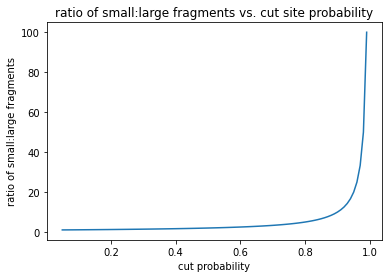

In [4]:
prob_ls, ratio_ls = [], []
for cut_prob in np.arange(0.05, 1, 0.01):
    prob_ls.append(cut_prob)
    site_range = 10 # expected neighboring sites in a 'cluster'
    window = 500
    n = 10000
    prob_dt = prob_dictionary(cut_prob, site_range)
    read_counts = get_read_counts(prob_dt, n)
    ratio_ls.append(print_ratios(read_counts))
    # define_clusters(site_ls, window)

plt.plot(prob_ls, ratio_ls)
plt.title('ratio of small:large fragments vs. cut site probability')
plt.xlabel('cut probability')
plt.ylabel('ratio of small:large fragments')

Proof of concept: using only the range of cut probabilities from above (prob_ls), plug in each probability into the function y to graph an identical plot.

Text(0, 0.5, 'ratio of small:large fragments')

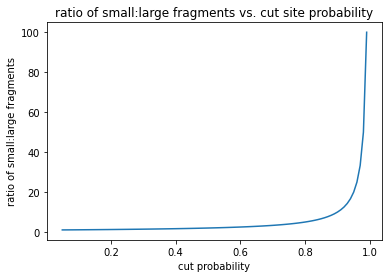

In [5]:
y = [(i**2) / ((i ** 2) * (1-i)) for i in prob_ls]
plt.plot(prob_ls, y)
plt.title('ratio of small:large fragments vs. cut site probability')
plt.xlabel('cut probability')
plt.ylabel('ratio of small:large fragments')

y = x^2 / (x^2 * (1-x))

Let's say we have an observed ratio of 5, assume no PCR bias or cut site biases.

5 = x^2 / (x^2 * (1-x))
5 = 1 / (1-x)  
5 - 5x = 1  
-5x = -4  
x = 4/5  
x = 0.8

In [6]:
ratio = 5
cut_prob = (ratio - 1)/(ratio)
print(cut_prob)

0.8


## derive cut site probability using simulated (95%) and empirical reads from GCA_000005845.2_ASM584v2

Open the bam positional information file, storing the start and end site of every mapped read.

The 'with_adapt' feature can be added to accomodate the length of the actual molecule during size selection.

### simulated data (95% cut probability)

In [7]:
df_95 = pd.read_csv('locs_95_percent_GCA_000005845.2_ASM584v2_genomic.txt', sep='\t', names=['read', 'chrom', 'start', 'end', 'length'])
df_95['abs_length'] = df_95['length'].abs()
df_95 = df_95[df_95['abs_length'] < 9500]
# df_95['with_adapt'] = df_95['abs_length'] + 135
df_95['with_adapt'] = df_95['abs_length'] + 0
df_95['counts'] = df_95.groupby(['read'])['abs_length'].transform('count')
df_95.head()

,read,chrom,start,end,length,abs_length,with_adapt,counts
0,70766:3075:540:505:na:na:GCA_000005845.2_ASM58...,U00096.3,3340,3475,507,507,507,2
1,70766:3075:540:505:na:na:GCA_000005845.2_ASM58...,U00096.3,3709,3846,-507,507,507,2
2,50742:1299:243:208:na:na:GCA_000005845.2_ASM58...,U00096.3,3843,3980,210,210,210,2
3,50743:1299:243:208:na:na:GCA_000005845.2_ASM58...,U00096.3,3843,3980,210,210,210,2
4,50744:1299:243:208:na:na:GCA_000005845.2_ASM58...,U00096.3,3843,3980,210,210,210,2


This step makes certain that reads are truly paired and that in situations where a unique read id occurs more than twice, anomalous (excessively long or distant) reads are removed.

In [8]:
tmp_df_95 = df_95[df_95['counts'] > 2]
df_95 = df_95[df_95['counts'] == 2]

tmp_df_95.reset_index(inplace=True, drop=True)

for_removal = []

for i in range(tmp_df_95.shape[0]):
    very_tmp = tmp_df_95[tmp_df_95['read'] == tmp_df_95.iloc[i]['read']]
    if very_tmp[very_tmp['abs_length'] == tmp_df_95.iloc[i]['abs_length']].shape[0] != 2:
        for_removal.append(i)
        
tmp_df_95.drop(for_removal, inplace=True)
df_95 = pd.concat([df_95, tmp_df_95], axis=0)

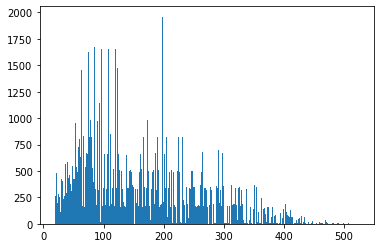

In [9]:
plt.hist(df_95['with_adapt'], bins = df_95['with_adapt'].max() - df_95['with_adapt'].min())
plt.show()

Compare with the readsynth output distribution of possible reads (red), 1X genome coverage (yellow), and adjusted relative probability before size-selction and scaling (blue).

![](hist_counts_GCA_000005845.2_ASM584v2_genomic.fna.png)

### real sequencing data (Snipen et al. reads mapped to K-12 E. coli; GCA_000005845.2) (raw reads)

In [10]:
df_snip = pd.read_csv('locs_snipen_SRR10199724_GCA_000005845.2_ASM584v2_genomic.txt', sep='\t', names=['read', 'chrom', 'start', 'end', 'length'])
df_snip['abs_length'] = df_snip['length'].abs()
df_snip = df_snip[df_snip['abs_length'] < 9500]
# df_snip['with_adapt'] = df_snip['abs_length'] + 135
df_snip['with_adapt'] = df_snip['abs_length'] + 0
df_snip['counts'] = df_snip.groupby(['read'])['abs_length'].transform('count')
df_snip.head()

,read,chrom,start,end,length,abs_length,with_adapt,counts
0,SRR10199724.86565,U00096.3,3340,3477,507,507,507,2
1,SRR10199724.87948,U00096.3,3340,3477,507,507,507,2
2,SRR10199724.106202,U00096.3,3340,3477,507,507,507,2
3,SRR10199724.144118,U00096.3,3340,3477,507,507,507,2
4,SRR10199724.172237,U00096.3,3340,3477,507,507,507,2


This step makes certain that reads are truly paired and that in situations where a unique read id occurs more than twice, anomalous (excessively long or distant) reads are removed.

In [11]:
tmp_df_snip = df_snip[df_snip['counts'] > 2]
df_snip = df_snip[df_snip['counts'] == 2]

tmp_df_snip.reset_index(inplace=True, drop=True)

for_removal = []

for i in range(tmp_df_snip.shape[0]):
    very_tmp = tmp_df_snip[tmp_df_snip['read'] == tmp_df_snip.iloc[i]['read']]
    if very_tmp[very_tmp['abs_length'] == tmp_df_snip.iloc[i]['abs_length']].shape[0] != 2:
        for_removal.append(i)
        
tmp_df_snip.drop(for_removal, inplace=True)
df_snip = pd.concat([df_snip, tmp_df_snip], axis=0)

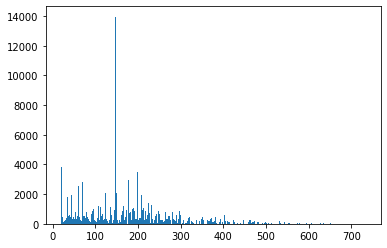

In [12]:
plt.hist(df_snip['with_adapt'], bins = df_snip['with_adapt'].max() - df_snip['with_adapt'].min())
plt.show()

### real sequencing data (cleaned to have consistent start/end positions)

In [ ]:
df_snip = pd.read_csv('../fragment_summaries/snipen_GCA_000005845_corrected.csv')
df_snip['with_adapt'] = df_snip['abs_length'] + 0
df_snip = df_snip.rename(columns={"id": "read", "for_pos": "start", "rev_pos": "end"})
df_snip['counts'] = df_snip.groupby(['read'])['abs_length'].transform('count')
df_snip.head()

In [ ]:
plt.hist(df_snip['with_adapt'], bins = df_snip['with_adapt'].max() - df_snip['with_adapt'].min())
plt.show()

This histogram doesn't perfectly match the simulated one above, possibly due to a different empirical cut probability or mismatched reads.

In [13]:
df_95.sort_values(by=['read', 'length'], ascending = (True, False), inplace=True)
df_95.reset_index(inplace=True, drop=True)
df_95['full_end'] = df_95['end'].shift(-1, axis=0)
df_95['full_length'] = (df_95['full_end'] - df_95['start']) + 1
df_95 = df_95[df_95['length'] > 0]
df_95.reset_index(inplace=True, drop=True)
df_95['diff'] = df_95['full_length'] - df_95['abs_length']

np_array = np.array(df_95)
loci_95 = {}

for i in range(np_array.shape[0]):
    tmp_tup = (np_array[i,:][2], np_array[i,:][2] + round(np_array[i,:][5]))
    if tmp_tup in loci_95:
        loci_95[tmp_tup] += 1
    else:
        loci_95[tmp_tup] = 1
print(len(loci_95))

1762


In [15]:
df_snip.sort_values(by=['read', 'length'], ascending = (True, False), inplace=True)
df_snip.reset_index(inplace=True, drop=True)
df_snip['full_end'] = df_snip['end']
df_snip['full_length'] = (df_snip['full_end'] - df_snip['start']) + 1
df_snip = df_snip[df_snip['length'] > 0]
df_snip.reset_index(inplace=True, drop=True)
df_snip['diff'] = df_snip['full_length'] - df_snip['abs_length']

np_array = np.array(df_snip)
loci_snip = {}

for i in range(np_array.shape[0]):
    tmp_tup = (np_array[i,:][2], np_array[i,:][2] + round(np_array[i,:][5]))
    if tmp_tup in loci_snip:
        loci_snip[tmp_tup] += 1
    else:
        loci_snip[tmp_tup] = 1
print(len(loci_snip))

5794


In [14]:
# df_snip.sort_values(by=['read', 'length'], ascending = (True, False), inplace=True)
# df_snip.reset_index(inplace=True, drop=True)
# df_snip['full_end'] = df_snip['end']
# df_snip['full_length'] = (df_snip['full_end'] - df_snip['start']) + 1
# df_snip = df_snip[df_snip['length'] > 0]
# df_snip.reset_index(inplace=True, drop=True)
# df_snip['diff'] = df_snip['full_length'] - df_snip['abs_length']

# np_array = np.array(df_snip)
# loci_snip = {}

# for i in range(np_array.shape[0]):
#     tmp_tup = (np_array[i,:][4], np_array[i,:][4] + round(np_array[i,:][11]))
#     if tmp_tup in loci_snip:
#         loci_snip[tmp_tup] += 1
#     else:
#         loci_snip[tmp_tup] = 1
# print(len(loci_snip))

IndexError: index 11 is out of bounds for axis 0 with size 11

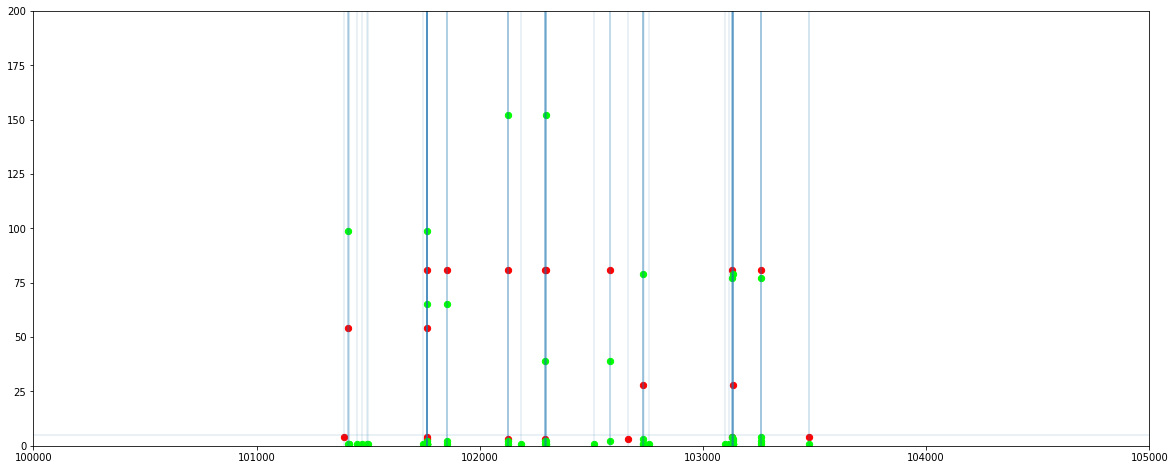

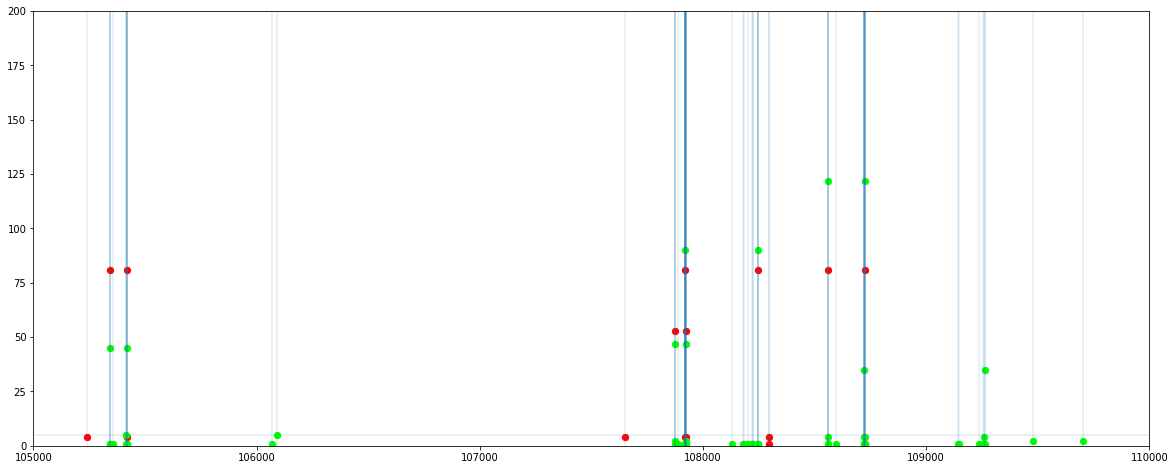

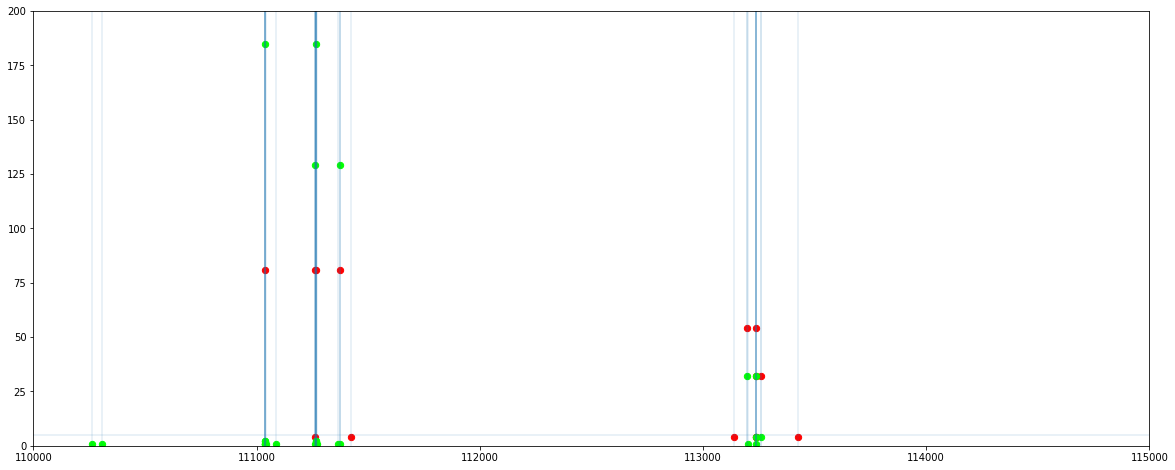

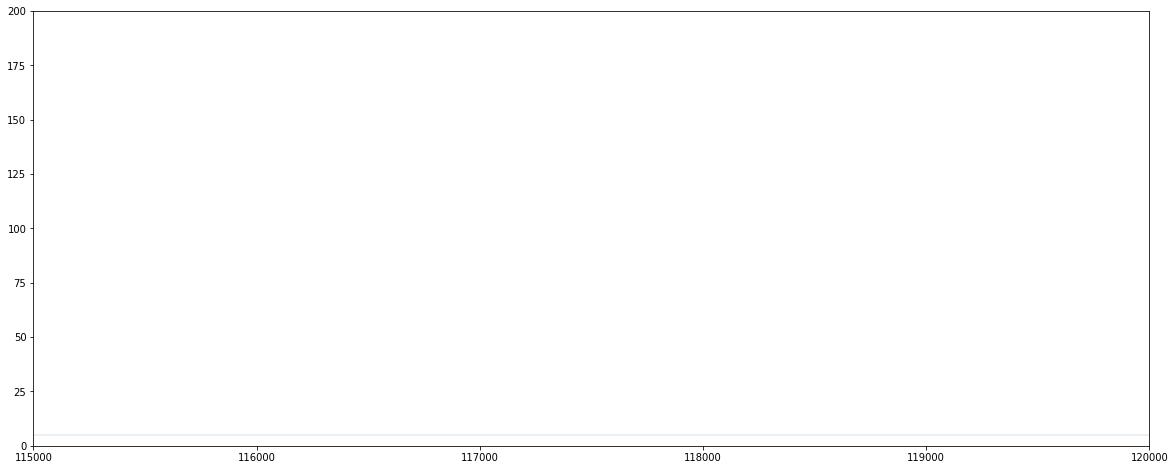

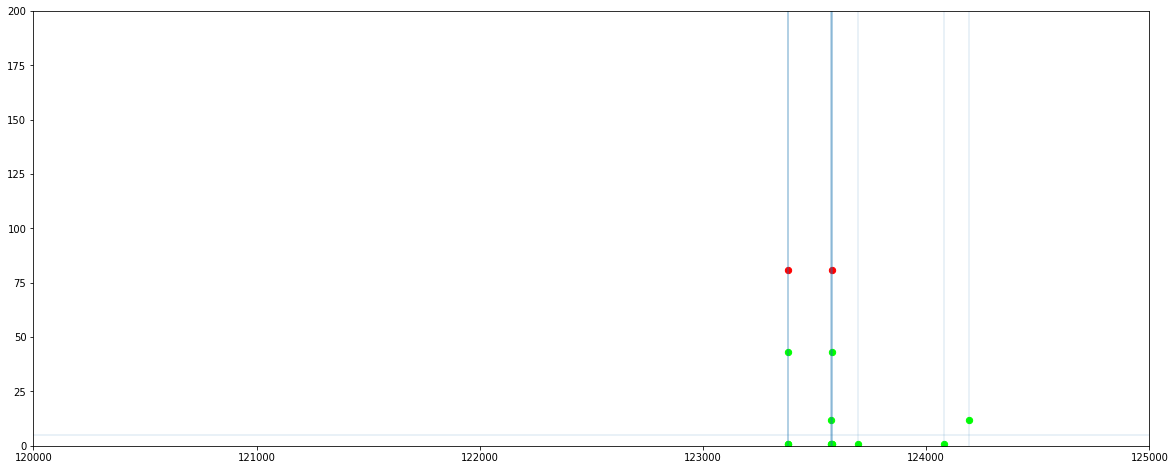

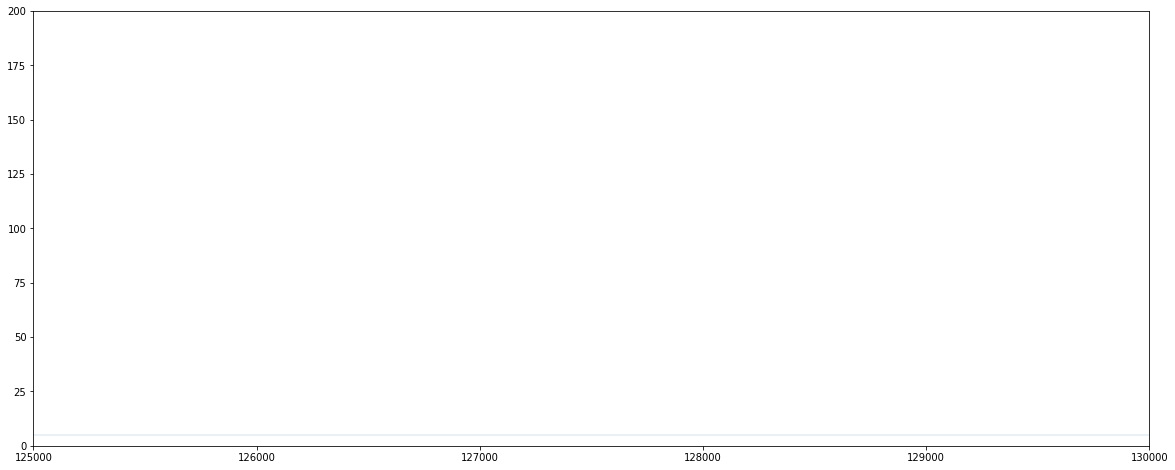

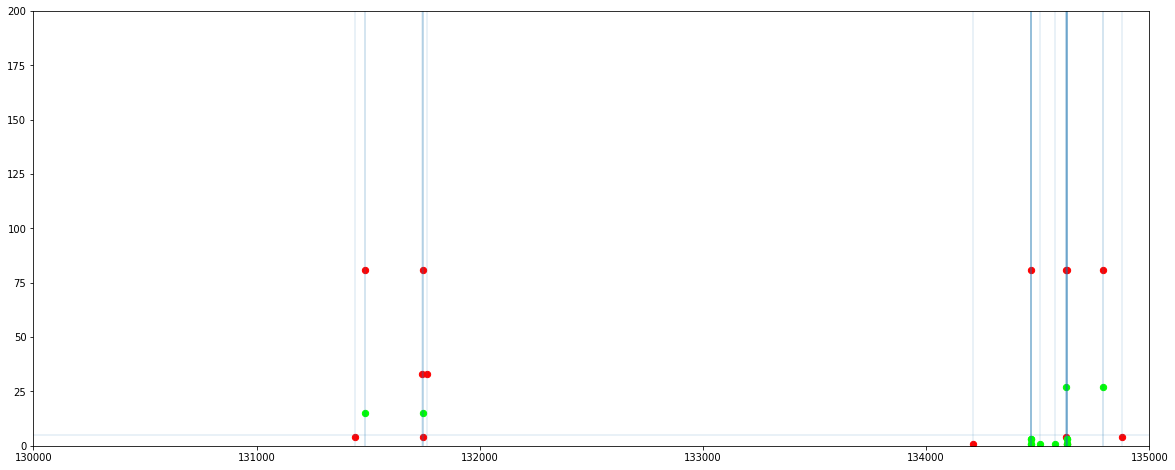

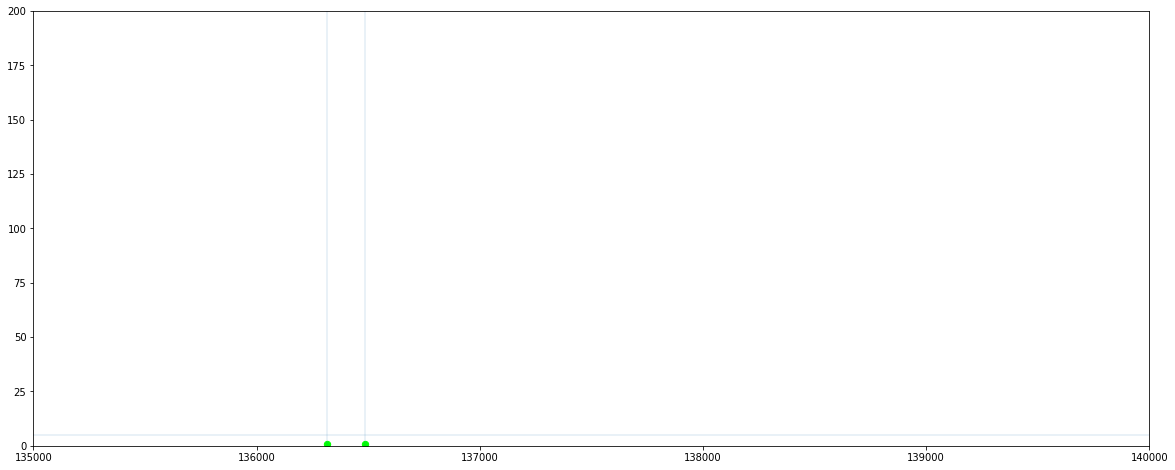

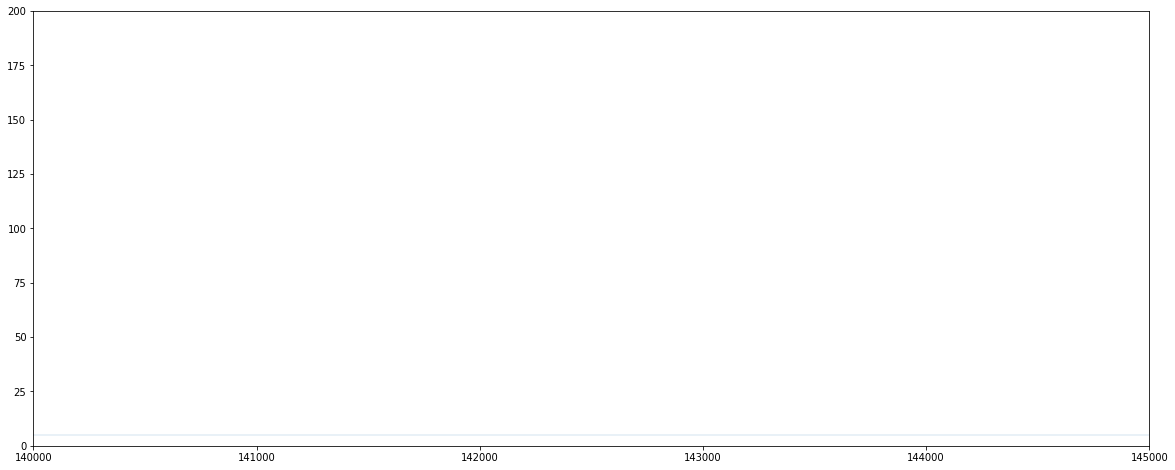

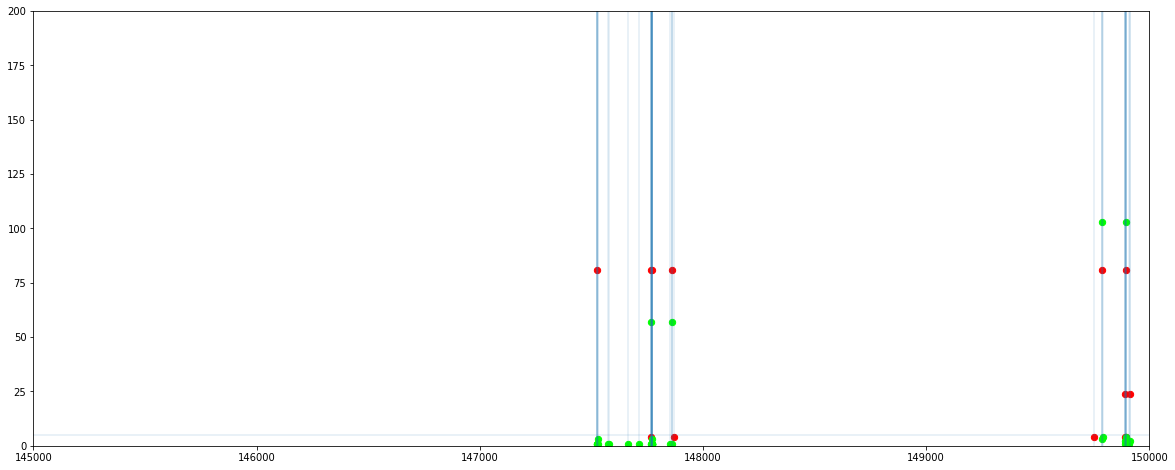

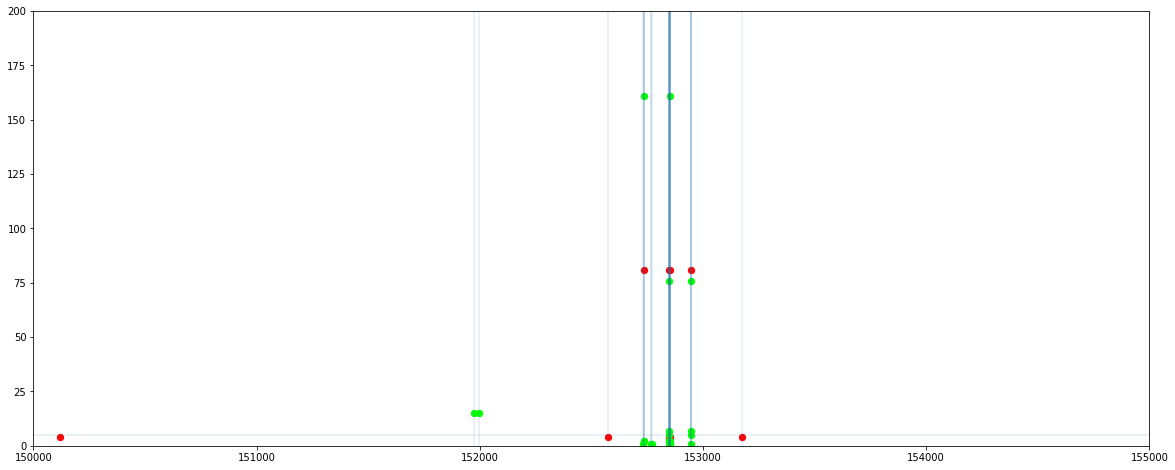

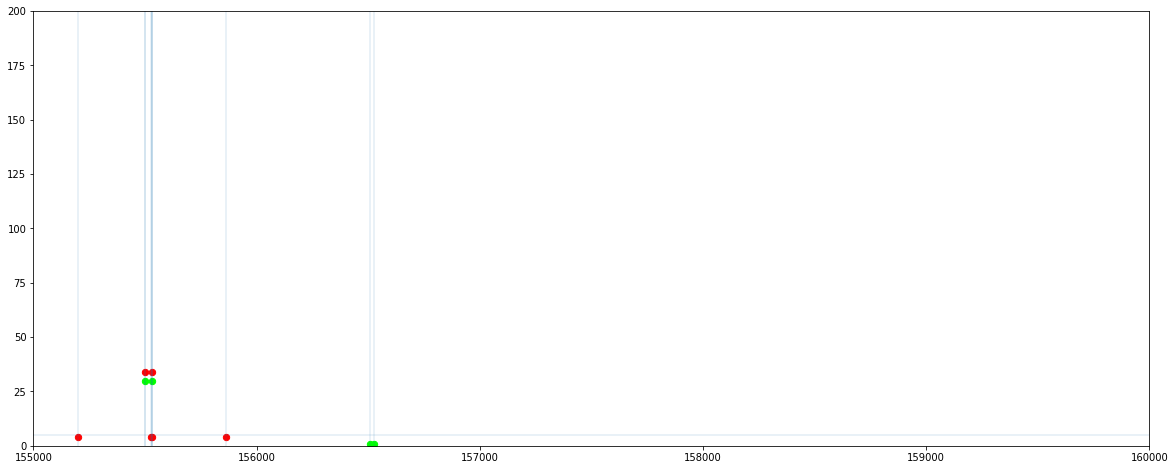

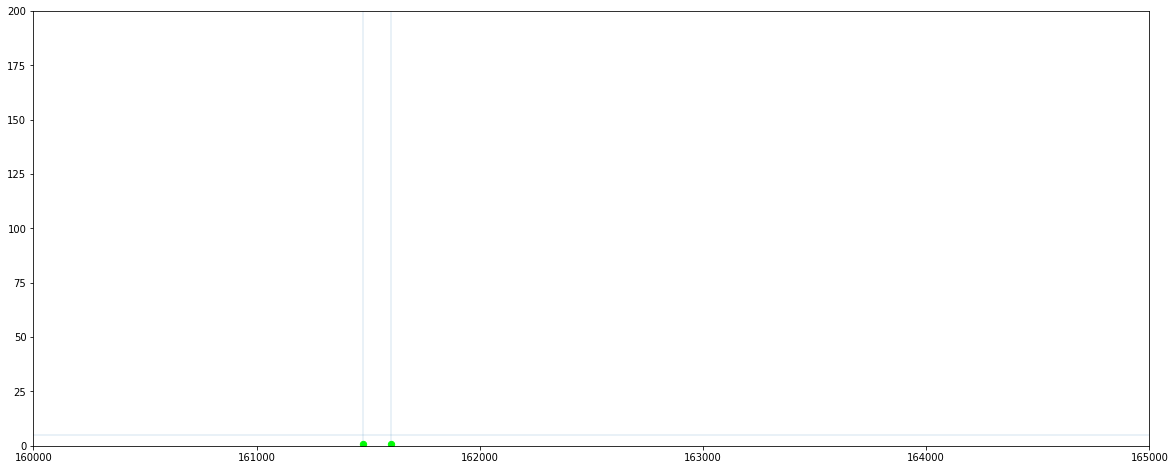

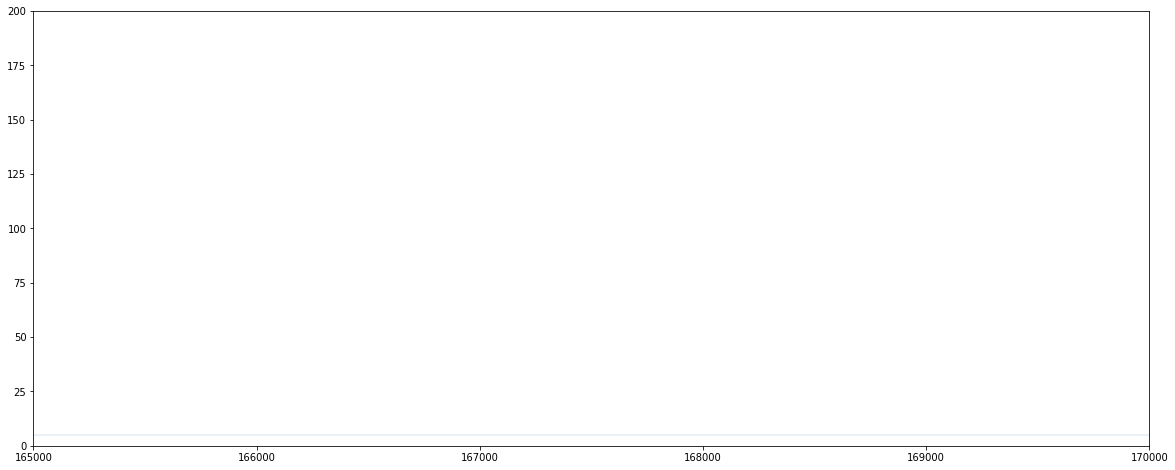

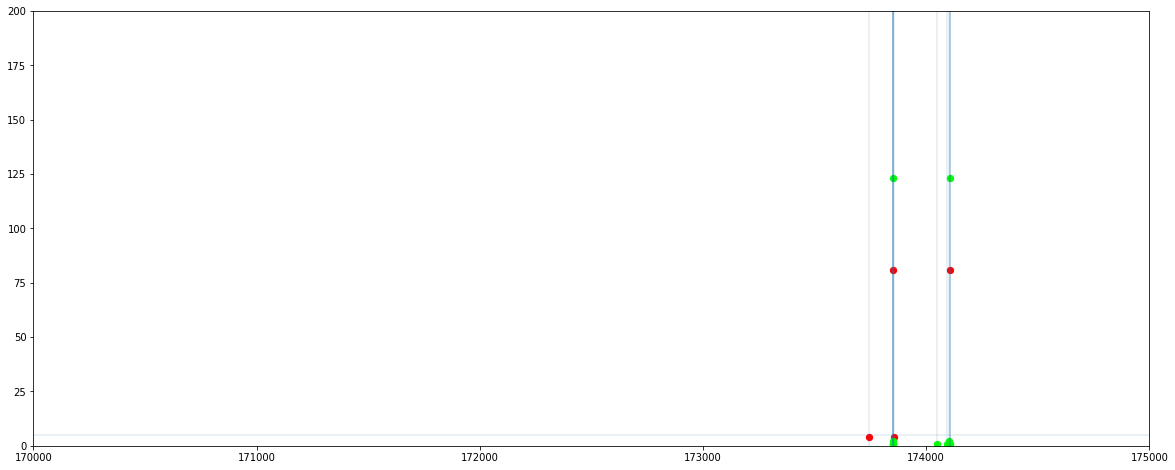

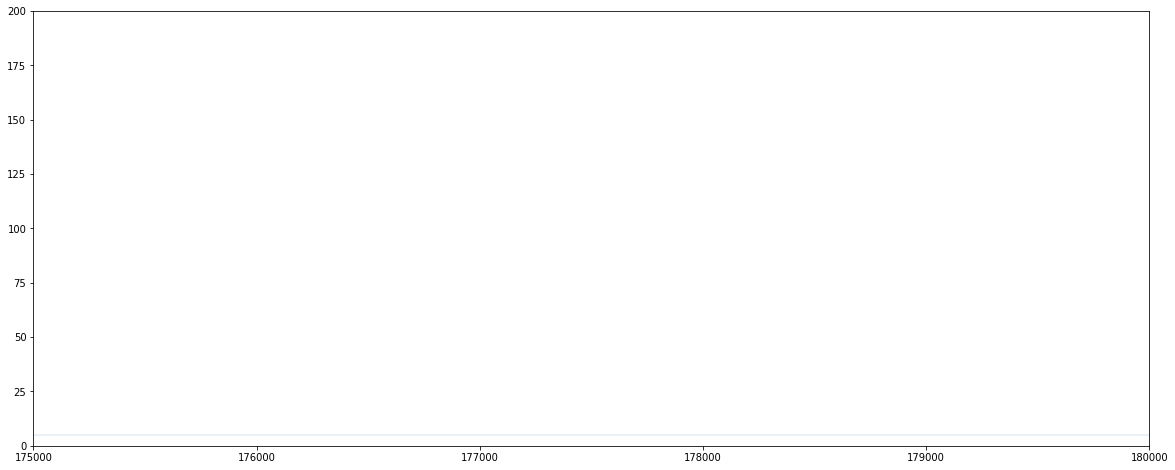

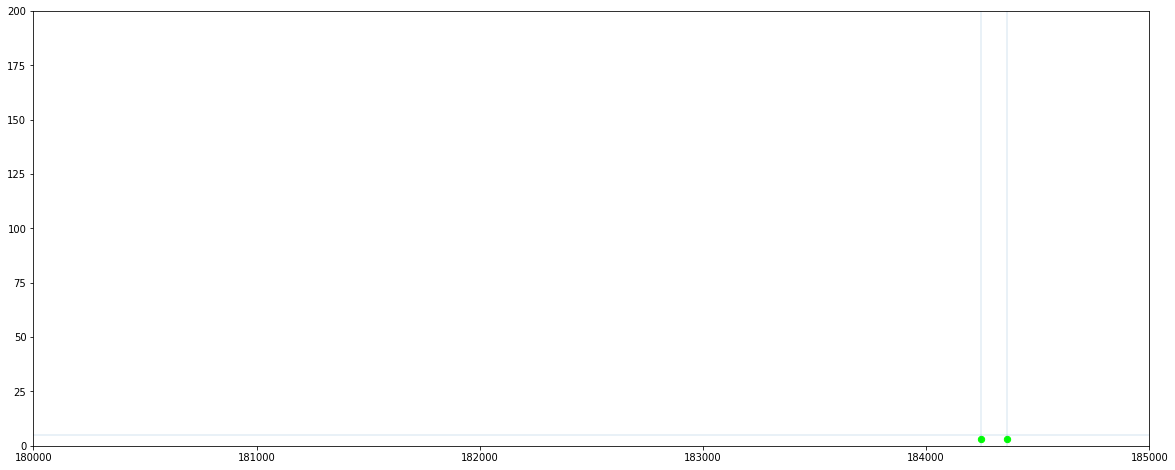

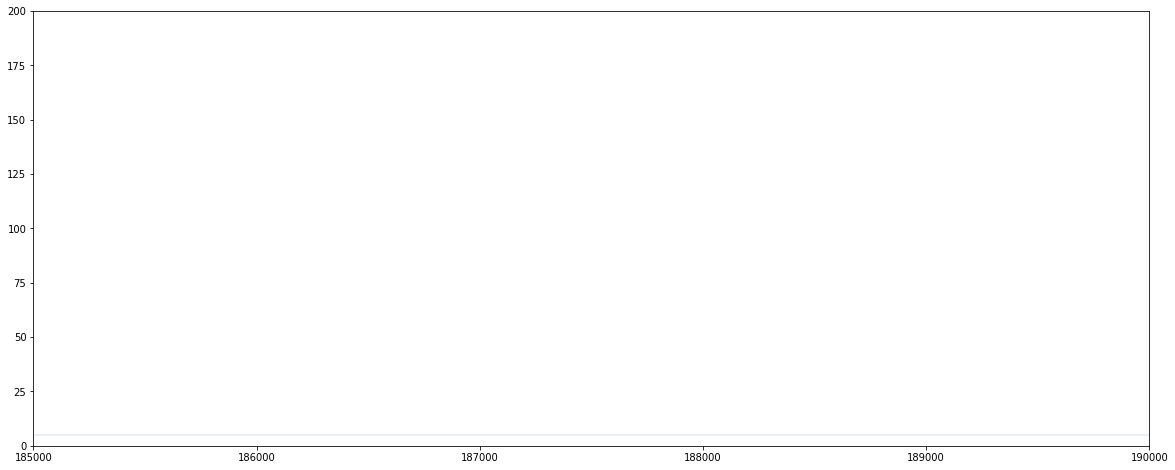

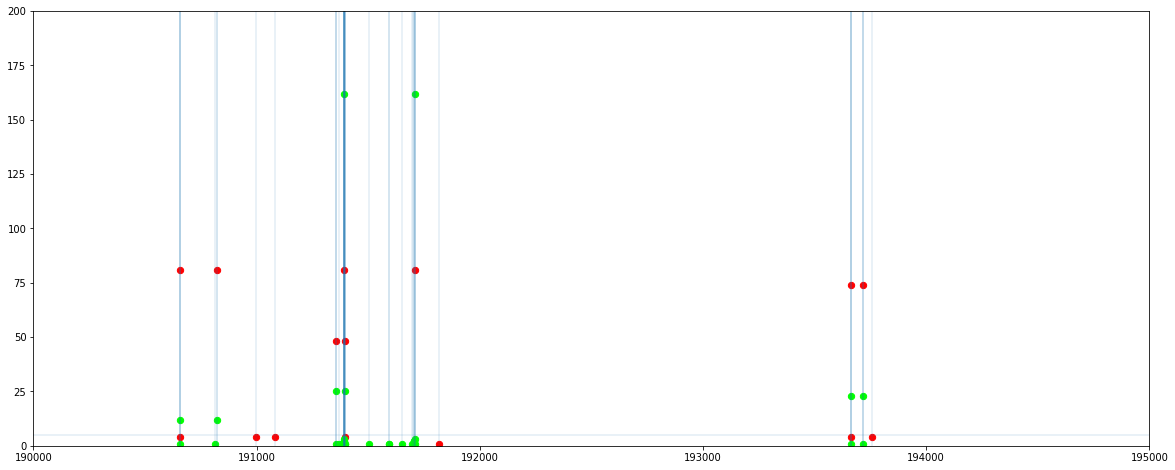

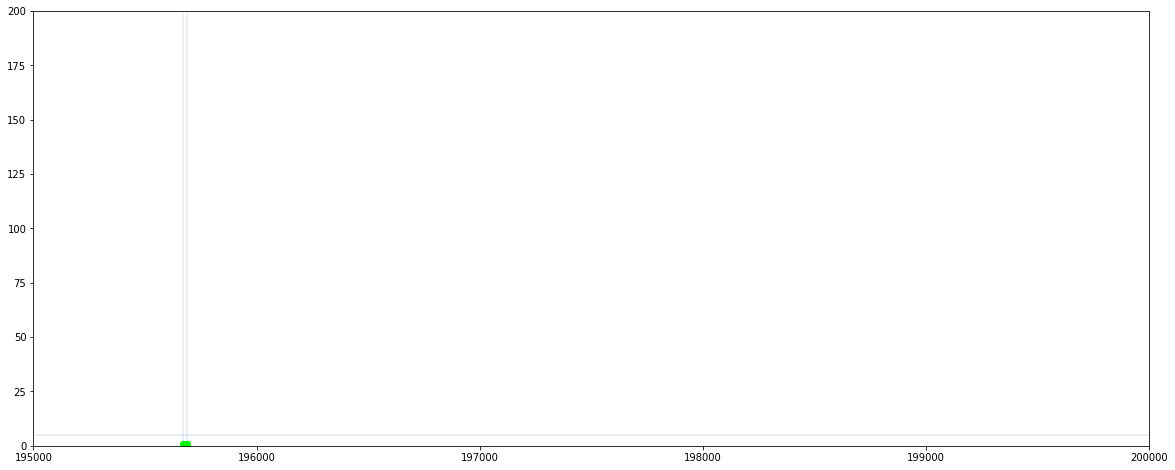

In [16]:
rez=5000

for i in range(100000, 200000, rez):
    plt.figure(figsize=(20,8))
    plt.scatter([i[0] for i in loci_95.keys()], loci_95.values(), s=40, color='red')
    plt.scatter([i[1] for i in loci_95.keys()], loci_95.values(), s=40, color='red')
    plt.scatter([i[0] for i in loci_snip.keys()], loci_snip.values(), s=40, color='lime')
    plt.scatter([i[1] for i in loci_snip.keys()], loci_snip.values(), s=40, color='lime')
    for j in loci_snip.keys():
        if i < j[0] < i + rez:
            plt.axvline(x=j[0], alpha=0.13)
            plt.axvline(x=j[1], alpha=0.13)
    for j in loci_95.keys():
        if i < j[0] < i + rez:
            plt.axvline(x=j[0], alpha=0.13)
            plt.axvline(x=j[1], alpha=0.13)
    plt.axhline(y=5, alpha=0.13)
    plt.xlim([i,i+rez])
    plt.ylim([0,200])
    plt.show()

## visualize relationship between internal cut sites, fragment len, and counts

In [17]:
all_cut_sites = []

for i in loci_95.keys():
    if i[0] not in all_cut_sites:
        all_cut_sites.append(i[0])
    if i[1] not in all_cut_sites:
        all_cut_sites.append(i[1])

all_cut_sites.sort()
print(len(all_cut_sites))

2842


In [18]:
mx_95 = []

for i, count in loci_95.items():
    start = all_cut_sites.index(i[0])
    end = all_cut_sites.index(i[1])
    mx_95.append([i[1]-i[0], end - start - 1, count])

mx_95 = np.array(mx_95)

In [19]:
mx_95

array([[57,  1, 51],
       [57,  1, 58],
       [57,  1, 44],
       ...,
       [56,  1,  3],
       [56,  1, 61],
       [57,  2,  3]])

In [52]:
from mpl_toolkits import mplot3d

x = mx_95[:,0]
y = mx_95[:,1]
z = mx_95[:,2]

In [53]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(scene = dict(
                    xaxis_title='read length (BP)',
                    yaxis_title='internal cut sites',
                    zaxis_title='read count'),
                    width=700,
                    margin=dict(r=0, b=0, l=0, t=0))
fig.show()

In [22]:
max_internals = np.max(mx_95[:,1])
last_target, last_internals, last_count = (0, 0), 0, 0
ratios = []

for idx, i in enumerate(all_cut_sites):
    for j in range(max_internals):
        try:
            target = (all_cut_sites[idx], all_cut_sites[idx+j+1])
        except IndexError:
            break
        if target in loci_95:
            if target[0] == last_target[0]:
                if j - last_internals == 1:
                    ratios.append([last_count, loci_95[target]])
            last_internals = j
            last_target = target
            last_count = loci_95[target]

In [23]:
ratios = pd.DataFrame(np.array(ratios), columns=['inner', 'outer'])
ratios['ratio'] = ratios['inner']/ratios['outer']

In [24]:
print(ratios)

ratios['ratio'].mean()

     inner  outer  ratio
0       81      2  40.50
1       81      4  20.25
2       81      4  20.25
3       81      3  27.00
4       81      4  20.25
..     ...    ...    ...
314     81      4  20.25
315     81      4  20.25
316     37      4   9.25
317     81      4  20.25
318     81      4  20.25

[319 rows x 3 columns]


22.38514371962648

In [25]:
def get_prob(ratio):
    return (1-ratio)/-ratio

print(get_prob(ratios['ratio'].median()))

0.9506172839506173


## try the snipen data

In [26]:
all_cut_sites = []

for i in loci_snip.keys():
    if i[0] not in all_cut_sites:
        all_cut_sites.append(i[0])
    if i[1] not in all_cut_sites:
        all_cut_sites.append(i[1])

all_cut_sites.sort()
print(len(all_cut_sites))

7326


In [27]:
mx_snip = []

for i, count in loci_snip.items():
    try:
        start = all_cut_sites.index(i[0])
        end = all_cut_sites.index(i[1])
        mx_snip.append([i[1]-i[0], end - start - 1, count])
    except ValueError:
        pass

mx_snip = np.array(mx_snip)

In [28]:
mx_snip

array([[198,   6, 132],
       [291,   5,  64],
       [481,  11,   1],
       ...,
       [158,   6,   1],
       [148,   5,   1],
       [ 54,  23,   1]])

In [54]:
from mpl_toolkits import mplot3d

x = mx_snip[:,0]
y = mx_snip[:,1]
z = mx_snip[:,2]

In [55]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(scene = dict(
                    xaxis_title='read length (BP)',
                    yaxis_title='internal cut sites',
                    zaxis_title='read count'),
                    width=700,
                    margin=dict(r=0, b=0, l=0, t=0))


fig.show()

In [31]:
max_internals = np.max(mx_snip[:,1])
last_target, last_internals, last_count = (0, 0), 0, 0
ratios = []

for idx, i in enumerate(all_cut_sites):
    for j in range(max_internals):
        try:
            target = (all_cut_sites[idx], all_cut_sites[idx+j+1])
        except IndexError:
            break
        if target in loci_snip:
            if target[0] == last_target[0]:
#                 print(all_cut_sites[idx:idx+j+2])
#                 print(last_target)
#                 print(target)
#                 print(last_internals, j)
                if j - last_internals == 1:
                    ratios.append([last_count, loci_snip[target]])
            last_internals = j
            last_target = target
            last_count = loci_snip[target]

In [32]:
ratios = pd.DataFrame(np.array(ratios), columns=['inner', 'outer'])
ratios['ratio'] = ratios['inner']/ratios['outer']

In [33]:
print(ratios)

ratios['ratio'].mean()

      inner  outer     ratio
0         1     30  0.033333
1        20    105  0.190476
2         1     63  0.015873
3         4    105  0.038095
4         1     55  0.018182
...     ...    ...       ...
1799      1      2  0.500000
1800      2     99  0.020202
1801      1     51  0.019608
1802      1      3  0.333333
1803      3    143  0.020979

[1804 rows x 3 columns]


14.287909621457565

y = x^2 / (x^2 * (1-x))

We have an observed ratio of 2, assume no PCR bias.

2 = x^2 / (x^2 * (1-x))

2 = 1 / (1-x)  
2 - 2x = 1  
-2x = -1  
x = 1/2  
x = 0.5

In [34]:
def get_prob(ratio):
    return (1-ratio)/-ratio

print(get_prob(ratios['ratio'].median()))

-2.0000000000000004


<AxesSubplot:>

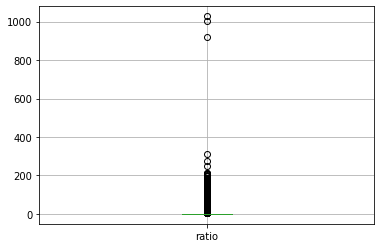

In [35]:
ratios.boxplot('ratio')

In [36]:
ratios['ratio'].median()

0.3333333333333333